In [1]:
import os
import random
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, accuracy_score

# Set random seed for reproducibility
torch.manual_seed(10)
np.random.seed(10)
random.seed(10)

# Define transformation with augmentation for training
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Standard transformation for testing (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets with appropriate transformations
train_ds = datasets.ImageFolder(root="train", transform=train_transform)
test_ds = datasets.ImageFolder(root="test", transform=test_transform)

# Data loaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=32, num_workers=4)

# Load AlexNet model
alexnet = models.alexnet(pretrained=True)
for param in alexnet.parameters():
    param.requires_grad = False

# Modify the classifier for the number of classes
num_ftrs = alexnet.classifier[6].in_features
alexnet.classifier[6] = nn.Linear(num_ftrs, len(train_ds.classes))

# Enable training for the classifier layers
for param in alexnet.classifier.parameters():
    param.requires_grad = True

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(alexnet.classifier.parameters(), lr=0.001)

# Training loop
epochs = 5
train_accuracies, test_accuracies = [], []

for epoch in range(epochs):
    print(f"\nStart of epoch {epoch+1}/{epochs}")
    start_time = time.time()
    train_loss, train_correct = 0, 0

    # Training phase
    alexnet.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = alexnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        train_correct += torch.sum(preds == labels.data).item()

    train_accuracy = train_correct / len(train_loader.dataset)
    train_accuracies.append(train_accuracy * 100)
    print(f'Train Accuracy: {train_accuracy * 100:.2f}%')

    # Testing phase
    test_loss, test_correct = 0, 0
    alexnet.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = alexnet(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            test_correct += torch.sum(preds == labels.data).item()

    test_accuracy = test_correct / len(test_loader.dataset)
    test_accuracies.append(test_accuracy * 100)
    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
    print(f'Duration: {time.time() - start_time:.0f}s')





Start of epoch 1/5
Train Accuracy: 49.99%
Test Accuracy: 77.33%
Duration: 106s

Start of epoch 2/5
Train Accuracy: 62.31%
Test Accuracy: 76.67%
Duration: 75s

Start of epoch 3/5
Train Accuracy: 63.03%
Test Accuracy: 86.00%
Duration: 81s

Start of epoch 4/5
Train Accuracy: 63.87%
Test Accuracy: 84.00%
Duration: 104s

Start of epoch 5/5
Train Accuracy: 65.56%
Test Accuracy: 86.67%
Duration: 87s


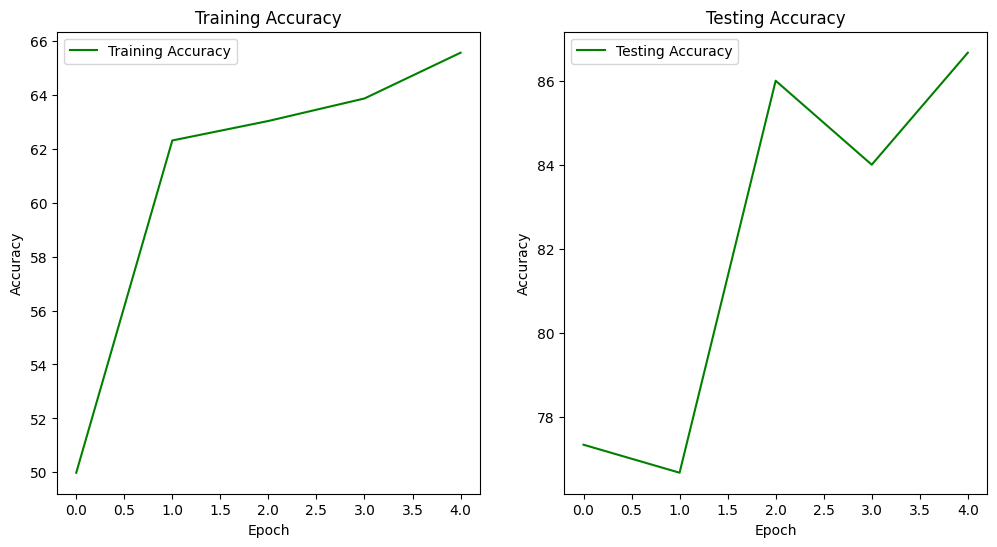

                   precision    recall  f1-score   support

         baseball       1.00      1.00      1.00         5
       basketball       1.00      0.60      0.75         5
       beachballs       1.00      1.00      1.00         5
    billiard ball       1.00      0.60      0.75         5
     bowling ball       1.00      0.80      0.89         5
            brass       0.75      0.60      0.67         5
      buckeyballs       1.00      1.00      1.00         5
      cannon ball       0.83      1.00      0.91         5
    chrochet ball       1.00      1.00      1.00         5
     cricket ball       1.00      1.00      1.00         5
     crystal ball       0.57      0.80      0.67         5
         eyeballs       1.00      1.00      1.00         5
         football       0.62      1.00      0.77         5
        golf ball       1.00      0.80      0.89         5
           marble       1.00      0.80      0.89         5
        meat ball       1.00      1.00      1.00       

In [2]:
# Visualization for training and testing accuracies
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy', color="green")
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Testing Accuracy', color="green")
plt.title('Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Final evaluation
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = alexnet(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())

report = classification_report(y_true, y_pred, labels=range(len(train_ds.classes)), target_names=train_ds.classes)
accuracy = accuracy_score(y_true, y_pred)
print(report)
print(f'Overall accuracy: {accuracy * 100:.2f}%')